Preparign to load the dataset 
Step 1: Data augmentated images where no of normal images = 2575, number of abnormal images = 2660(After augemntating the dataset in order to avoid class imbalance before augmenting the dataset number of normal images = 2575 and number of abnormal images = 600)

In order to re-produce the results the random seed value is already pre-defined in the code below.

In [2]:
import random
import numpy as np
import torch

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


The dataset was audio dataset in the file data_preprocessing all the audio data have been converted into spectrograms in order to test and understand how image data affects the architecture in terms of the following:
1. Computation
2. Metrics, The images have been converted into spectrograms via Short Time fourier transform


All images will be converted into grayscale channel (channel = 1) as there will be a lot of number of features in the first layer of fully connected neural network which will be difficult and complicated to handle with a less complex network. Initially setting the image size = 100x100

In [3]:
import numpy as np
from PIL import Image
import glob
import os
def load_image(dataset_dir, size=(100,100)):
    X1=[]   
    y1=[] 
    classes={
        "normal" :0,
        "abnormal": 1
    }
    for class_name, class_label in classes.items():
        folder = os.path.join(dataset_dir,class_name)
        image_paths = glob.glob(folder+"/*.png")
        for path in image_paths:
            img = Image.open(path)
            img = Image.open(path).convert('L')
            img = img.resize(size)
            arr = np.array(img, dtype=np.float32)/255.0
            arr = arr.flatten()
            X1.append(arr)
            y1.append(class_label)
    X = np.array(X1)
    Y = np.array(y1)
    return X,Y


In [4]:
X,Y = load_image("C:/Users/HP/Downloads/dataset-fro-programming&mathsforAI/spectrogramprocessedata/heartbeat-dataset")

Splitting the dataset into training, testing and validation in the ratio 80:20:10

In [5]:
import numpy as np

def train_val_test_split(X, y, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=None):
    N = len(X)
    idx = np.arange(N)
    np.random.shuffle(idx)

    train_end = int(N * train_ratio)
    val_end = train_end + int(N * val_ratio)

    train_idx = idx[:train_end]
    val_idx = idx[train_end:val_end]
    test_idx = idx[val_end:]

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    return X_train, y_train, X_val, y_val, X_test, y_test



In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, Y, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=42)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (4188, 10000) (4188,)
Validation: (523, 10000) (523,)
Test: (524, 10000) (524,)


Building layers of neural network for different experiments for grayscale specotrgram images obtained after pre-processing the audio data.

In [7]:
class Linear:
    def __init__(self, in_dim, out_dim):
        self.W = np.random.randn(in_dim, out_dim) * np.sqrt(2 / in_dim)
        self.b = np.zeros((out_dim,))

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, grad_out, l2=0.0):
        self.dW = self.x.T @ grad_out + l2*self.W
        self.db = np.sum(grad_out, axis=0)
        return grad_out @ self.W.T


In [8]:
class ReLU:
    def forward(self, x):
        self.mask = (x > 0)
        return x * self.mask

    def backward(self, grad_out):
        return grad_out * self.mask

In [9]:
def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp = np.exp(z)
    return exp / np.sum(exp, axis=1, keepdims=True)

def cross_entropy(pred, y):
    N = y.shape[0]
    p = pred[range(N), y]
    return -np.mean(np.log(p + 1e-12))

def softmax_backward(pred, y):
    grad = pred.copy()
    grad[np.arange(len(y)), y] -= 1
    return grad / len(y)


In [10]:
class Dropout:
    def __init__(self, p=0.2):
        self.p = p
        self.mask = None

    def forward(self, x, training=True):
        if training:
            keep = 1 - self.p
            self.mask = (np.random.rand(*x.shape) < keep).astype(float)
            return x * self.mask   
        else:
            return x * (1 - self.p)

    def backward(self, grad_out):
        return grad_out * self.mask


In [11]:
class SimpleNN:
    def __init__(self, input_dim, hidden_dims=[], output_dim=2, dropout_p=0.0):
        self.layers = []
        self.activations = []
        self.dropouts = []

        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layer = Linear(prev_dim, hidden_dim)
            self.layers.append(layer)
            self.activations.append(ReLU())
            self.dropouts.append(Dropout(p=dropout_p))
            prev_dim = hidden_dim

        output_layer = Linear(prev_dim, output_dim)
        self.layers.append(output_layer)  

    def forward(self, x, training=True):
        out = x
        for i in range(len(self.layers) - 1):  
            out = self.layers[i].forward(out)
            out = self.activations[i].forward(out)
            out = self.dropouts[i].forward(out, training=training)
        out = self.layers[-1].forward(out)
        return out

    def backward(self, grad, l2=0.0):

        grad = self.layers[-1].backward(grad, l2=l2)

        for i in reversed(range(len(self.layers)-1)):
            grad = self.dropouts[i].backward(grad)
            grad = self.activations[i].backward(grad)
            grad = self.layers[i].backward(grad, l2=l2)
        return grad

    def update(self, lr):
        for layer in self.layers:
            layer.W -= lr * layer.dW
            layer.b -= lr * layer.db

    def predict(self, X):
        logits = self.forward(X, training=False)
        probs = softmax(logits)
        return np.argmax(probs, axis=1)


In [ ]:
def confusion_matrix(y_true, y_pred, num_classes=2):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes=['normal', 'abnormal']):
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


In [13]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

def train(model, X_train, y_train, X_val, y_val, X_test, y_test, lr=0.001, epochs=30, l2=0.0):

    history = {
        "loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "test_acc": [],
        "precision": [],
        "recall": [],
        "f1": []
    }

    for epoch in range(epochs):

        logits = model.forward(X_train, training=True)
        probs = softmax(logits)
        loss = cross_entropy(probs, y_train)
        loss += (l2 / 2) * sum(np.sum(layer.W**2) for layer in model.layers)
        grad = softmax_backward(probs, y_train)
        model.backward(grad, l2=l2)
        model.update(lr)

        val_logits = model.forward(X_val, training=False)
        val_probs  = softmax(val_logits)
        val_loss   = cross_entropy(val_probs, y_val)
        val_loss  += (l2 / 2) * sum(np.sum(layer.W**2) for layer in model.layers)

        train_preds = model.predict(X_train)
        val_preds   = model.predict(X_val)
        test_preds  = model.predict(X_test)

        train_acc = accuracy(y_train, train_preds)
        val_acc   = accuracy(y_val, val_preds)
        test_acc  = accuracy(y_test, test_preds)

        prec = precision_score(y_test, test_preds, average='macro')
        rec  = recall_score(y_test, test_preds, average='macro')
        f1   = f1_score(y_test, test_preds, average='macro')

        history["loss"].append(loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["test_acc"].append(test_acc)
        history["precision"].append(prec)
        history["recall"].append(rec)
        history["f1"].append(f1)


        print(f"Epoch {epoch+1}/{epochs}  Loss={loss:.4f}  "
              f"TrainAcc={train_acc:.4f}  ValAcc={val_acc:.4f}  TestAcc={test_acc:.4f}  "
              f"Prec={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")

    # --- Final evaluation ---
    final_train_preds = model.predict(X_train)
    final_val_preds   = model.predict(X_val)
    final_test_preds  = model.predict(X_test)

    print("\n=== Final Accuracy ===")
    print(f"Train Accuracy : {accuracy(y_train, final_train_preds):.4f}")
    print(f"Validation Accuracy : {accuracy(y_val, final_val_preds):.4f}")
    print(f"Test Accuracy  : {accuracy(y_test, final_test_preds):.4f}")

    cm = confusion_matrix(y_test, final_test_preds)
    print("\nConfusion Matrix:\n", cm)
    plot_confusion_matrix(cm)

    return history


In [15]:
def model_summary(model):
    print("Layer (type)        Input → Output       Activation/Dropout     # Parameters")
    print("-"*80)
    
    for i, layer in enumerate(model.layers):
        in_dim, out_dim = layer.W.shape
        params = in_dim * out_dim + out_dim

        if i < len(model.layers) - 1:  
            activation = "ReLU"
            dropout = f"p={model.dropouts[i].p}" if model.dropouts else ""
        else:
            activation = ""
            dropout = ""

        print(f"{i+1:2d} ({'Linear':<6})     {in_dim} → {out_dim:<6}       {activation:<6} {dropout:<6}     {params}")
    
    total_params = sum(layer.W.size + layer.b.size for layer in model.layers)
    print("-"*80)
    print(f"Total parameters: {total_params}")


**Experiment 1 :**
\
input layer(10,000) -> hidden layer (400) -> output layer (2)\
number of epochs = 30
\
learning rate = 0.001
\
l2 = 0.00
\
optimizer = SGD
\
image size = 100x100
\
Dropout = No drop out 
\
Activation function = Sigmoid(), ReLU()


In [16]:
model = SimpleNN(input_dim=X_train.shape[1], hidden_dims=[400], output_dim=2, dropout_p=0.2)

In [17]:
model_summary(model)

Layer (type)        Input → Output       Activation/Dropout     # Parameters
--------------------------------------------------------------------------------
 1 (Linear)     10000 → 400          ReLU   p=0.2      4000400
 2 (Linear)     400 → 2                              802
--------------------------------------------------------------------------------
Total parameters: 4001202


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30  Loss=1.2418  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141
Epoch 2/30  Loss=0.7830  TrainAcc=0.4988  ValAcc=0.5277  TestAcc=0.5401  Prec=0.2706  Recall=0.4982  F1=0.3507
Epoch 3/30  Loss=0.7499  TrainAcc=0.5031  ValAcc=0.4742  TestAcc=0.4656  Prec=0.7308  Recall=0.5070  F1=0.3297
Epoch 4/30  Loss=0.7359  TrainAcc=0.5002  ValAcc=0.5277  TestAcc=0.5344  Prec=0.4969  Recall=0.4991  F1=0.4081
Epoch 5/30  Loss=0.7275  TrainAcc=0.5513  ValAcc=0.5258  TestAcc=0.5153  Prec=0.6557  Recall=0.5502  F1=0.4383
Epoch 6/30  Loss=0.7248  TrainAcc=0.5633  ValAcc=0.6119  TestAcc=0.5592  Prec=0.5508  Recall=0.5455  F1=0.5392
Epoch 7/30  Loss=0.7216  TrainAcc=0.6022  ValAcc=0.5717  TestAcc=0.6031  Prec=0.6565  Recall=0.6235  F1=0.5881
Epoch 8/30  Loss=0.7240  TrainAcc=0.6156  ValAcc=0.6061  TestAcc=0.6126  Prec=0.6270  Recall=0.6223  F1=0.6111
Epoch 9/30  Loss=0.7288  TrainAcc=0.6139  ValAcc=0.5870  TestAcc=0.6126  Prec=0.6589  Recall=0.6313  F1=0.6011
E

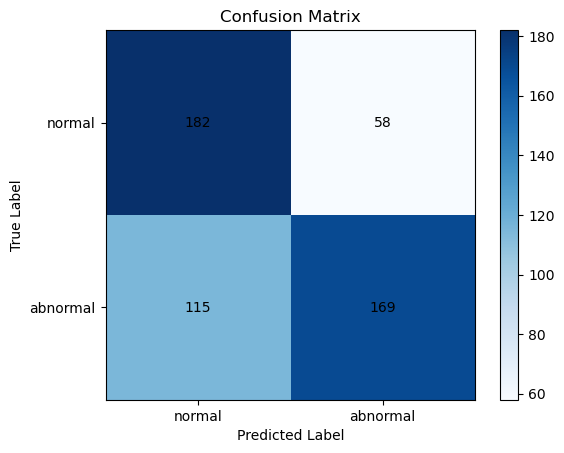

In [18]:
Experiment1 = train(
    model, 
    X_train, y_train, 
    X_val, y_val,
    X_test, y_test,
    lr=0.001,       
    epochs=30,    
    l2=0.00     
)


In [19]:
import matplotlib.pyplot as plt

def plot_experiment_history(history, title_prefix="Experiment"):
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history["loss"], label="Train Loss")
    if "val_loss" in history:
        plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history["precision"], label="Precision")
    plt.plot(epochs, history["recall"], label="Recall")
    plt.plot(epochs, history["f1"], label="F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title(f"{title_prefix} - Test Metrics vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


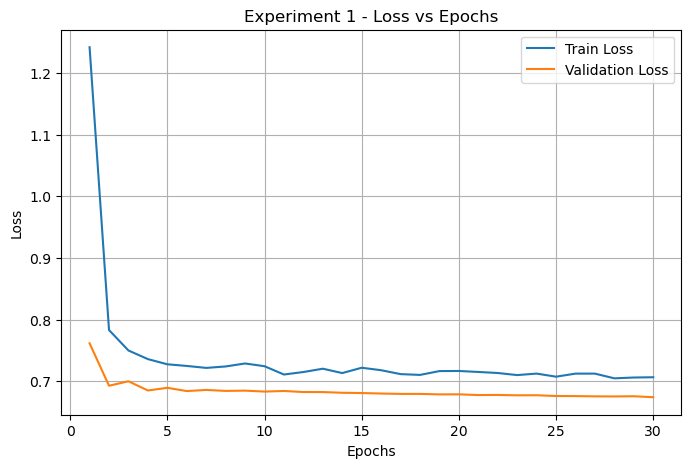

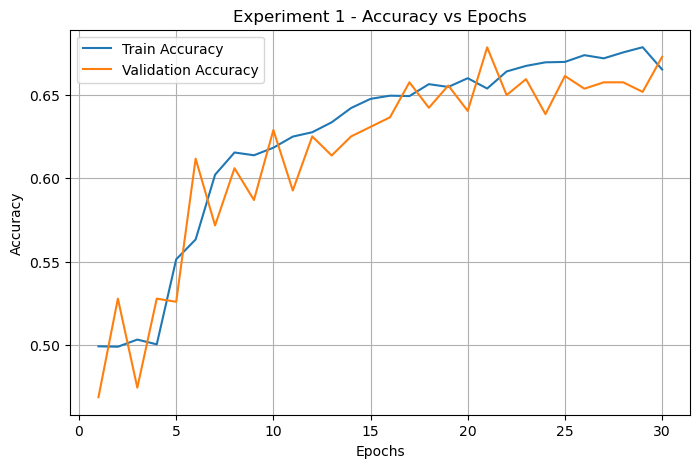

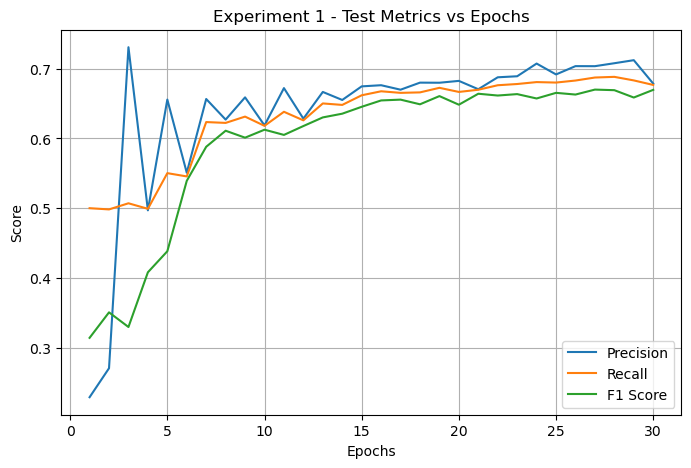

In [20]:
plot_experiment_history(Experiment1, title_prefix="Experiment 1")


**Experiment 2 :**
\
input layer(10,000) -> hidden layer_1 (8000) -> hidden_layer_2 (4000) -> hidden layer_2(2000) ->  hidden_layer_3 (500) -> output layer (2)\
number of epochs = 30
\
learning rate = 0.001
\
l2 = 0.00
\
optimizer = SGD
\
image size = 100x100
\
Dropout = No drop out 
\
Activation function = Sigmoid(), ReLU()


In [21]:
model_exp2 = SimpleNN(input_dim=X_train.shape[1], hidden_dims=[8000, 4000, 2000, 500], output_dim=2, dropout_p=0.0)

In [22]:
model_summary(model_exp2)

Layer (type)        Input → Output       Activation/Dropout     # Parameters
--------------------------------------------------------------------------------
 1 (Linear)     10000 → 8000         ReLU   p=0.0      80008000
 2 (Linear)     8000 → 4000         ReLU   p=0.0      32004000
 3 (Linear)     4000 → 2000         ReLU   p=0.0      8002000
 4 (Linear)     2000 → 500          ReLU   p=0.0      1000500
 5 (Linear)     500 → 2                              1002
--------------------------------------------------------------------------------
Total parameters: 121015502


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30  Loss=0.8416  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/30  Loss=2.0135  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/30  Loss=2.0754  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/30  Loss=1.2942  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/30  Loss=1.5807  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/30  Loss=1.2577  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/30  Loss=1.2827  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/30  Loss=1.1790  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/30  Loss=1.1486  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10/30  Loss=1.0989  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11/30  Loss=1.0489  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12/30  Loss=0.9960  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13/30  Loss=1.0298  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14/30  Loss=1.0122  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15/30  Loss=1.0045  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16/30  Loss=0.9767  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 17/30  Loss=0.9648  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18/30  Loss=0.9376  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 19/30  Loss=0.9042  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/30  Loss=0.8719  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 21/30  Loss=0.8733  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 22/30  Loss=0.8556  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23/30  Loss=0.8440  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 24/30  Loss=0.8246  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 25/30  Loss=0.8223  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 26/30  Loss=0.8060  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 27/30  Loss=0.8023  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 28/30  Loss=0.7913  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 29/30  Loss=0.7926  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 30/30  Loss=0.7804  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141

=== Final Accuracy ===
Train Accuracy : 0.4990
Validation Accuracy : 0.4685
Test Accuracy  : 0.4580

Confusion Matrix:
 [[240   0]
 [284   0]]


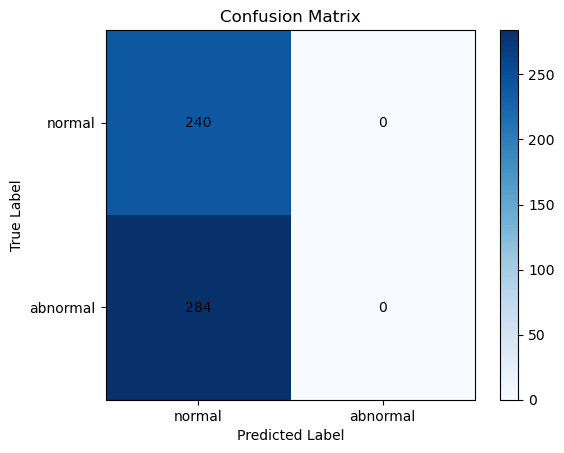

In [23]:
Experiment2 = train(
    model_exp2, 
    X_train, y_train, 
    X_val, y_val,
    X_test, y_test,
    lr=0.001,       
    epochs=30,    
    l2=0.00     
)


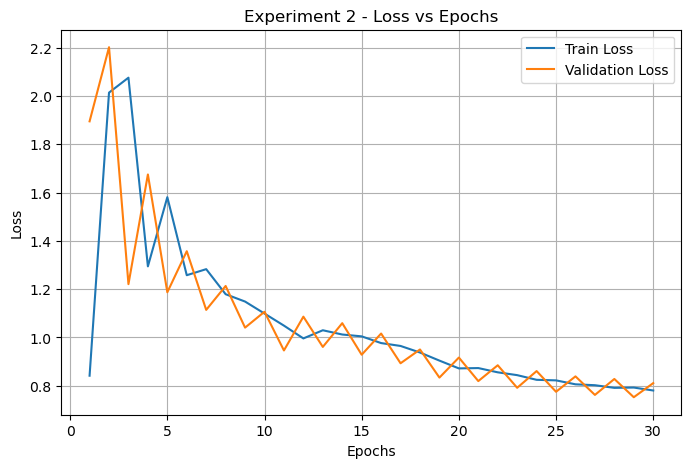

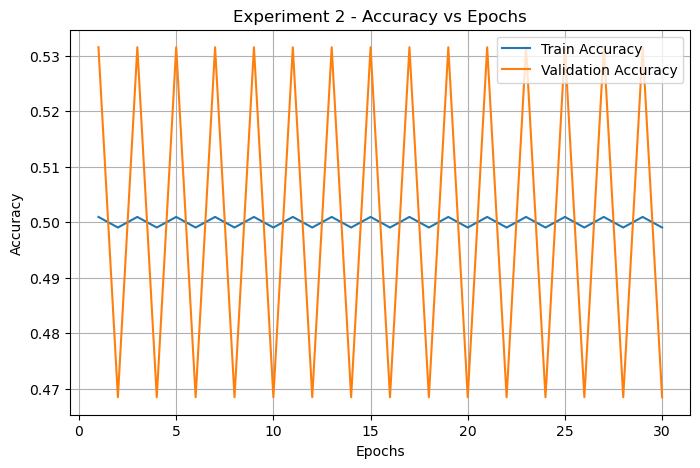

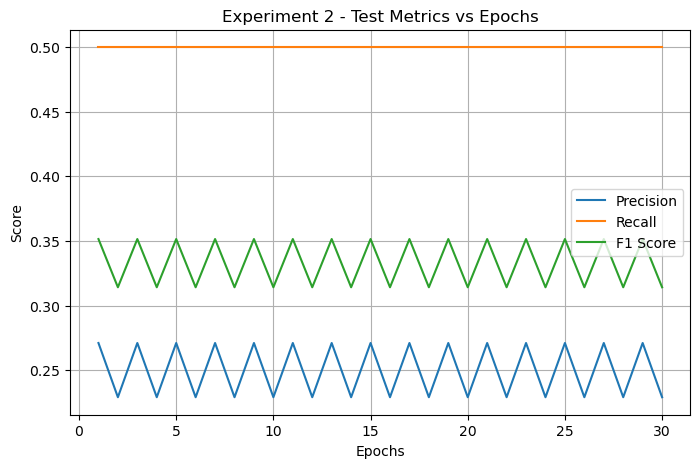

In [24]:
plot_experiment_history(Experiment2, title_prefix="Experiment 2")


**Experiment 3 :**
\
input layer(10,000) -> hidden layer_1 (5000) -> hidden_layer_2(1000) -> hidden_layer (500) -> output layer (2)\
number of epochs = 30
\
learning rate = 0.01
\
l2 = 0.00
\
optimizer = SGD
\
image size = 100x100
\
Dropout = 20%
\
Activation function = Sigmoid(), ReLU()


In [25]:
model_exp3 = SimpleNN(input_dim=X_train.shape[1], hidden_dims=[5000, 1000, 500], output_dim=2, dropout_p=0.2)

In [26]:
model_summary(model_exp3)

Layer (type)        Input → Output       Activation/Dropout     # Parameters
--------------------------------------------------------------------------------
 1 (Linear)     10000 → 5000         ReLU   p=0.2      50005000
 2 (Linear)     5000 → 1000         ReLU   p=0.2      5001000
 3 (Linear)     1000 → 500          ReLU   p=0.2      500500
 4 (Linear)     500 → 2                              1002
--------------------------------------------------------------------------------
Total parameters: 55507502


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30  Loss=0.7991  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/30  Loss=1.6457  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/30  Loss=2.8556  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/30  Loss=0.8558  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/30  Loss=0.7484  TrainAcc=0.4990  ValAcc=0.4685  TestAcc=0.4580  Prec=0.2290  Recall=0.5000  F1=0.3141


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/30  Loss=0.7183  TrainAcc=0.5010  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515
Epoch 7/30  Loss=0.7084  TrainAcc=0.5038  ValAcc=0.5296  TestAcc=0.5401  Prec=0.4373  Recall=0.4986  F1=0.3544


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/30  Loss=0.7032  TrainAcc=0.5014  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515
Epoch 9/30  Loss=0.7028  TrainAcc=0.5017  ValAcc=0.5315  TestAcc=0.5401  Prec=0.2706  Recall=0.4982  F1=0.3507
Epoch 10/30  Loss=0.7061  TrainAcc=0.5026  ValAcc=0.5315  TestAcc=0.5401  Prec=0.4373  Recall=0.4986  F1=0.3544


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11/30  Loss=0.7033  TrainAcc=0.5017  ValAcc=0.5315  TestAcc=0.5420  Prec=0.2710  Recall=0.5000  F1=0.3515
Epoch 12/30  Loss=0.6986  TrainAcc=0.5024  ValAcc=0.5315  TestAcc=0.5401  Prec=0.4373  Recall=0.4986  F1=0.3544
Epoch 13/30  Loss=0.7052  TrainAcc=0.5041  ValAcc=0.5335  TestAcc=0.5439  Prec=0.5717  Recall=0.5027  F1=0.3634
Epoch 14/30  Loss=0.6988  TrainAcc=0.5134  ValAcc=0.5411  TestAcc=0.5496  Prec=0.6068  Recall=0.5096  F1=0.3835
Epoch 15/30  Loss=0.6986  TrainAcc=0.5072  ValAcc=0.5411  TestAcc=0.5458  Prec=0.6055  Recall=0.5048  F1=0.3679
Epoch 16/30  Loss=0.7024  TrainAcc=0.5131  ValAcc=0.5430  TestAcc=0.5496  Prec=0.6068  Recall=0.5096  F1=0.3835
Epoch 17/30  Loss=0.6955  TrainAcc=0.5153  ValAcc=0.5392  TestAcc=0.5496  Prec=0.6068  Recall=0.5096  F1=0.3835
Epoch 18/30  Loss=0.6972  TrainAcc=0.5267  ValAcc=0.5526  TestAcc=0.5534  Prec=0.5875  Recall=0.5154  F1=0.4076
Epoch 19/30  Loss=0.6972  TrainAcc=0.5451  ValAcc=0.5641  TestAcc=0.5840  Prec=0.6370  Recall=0.5510  F1

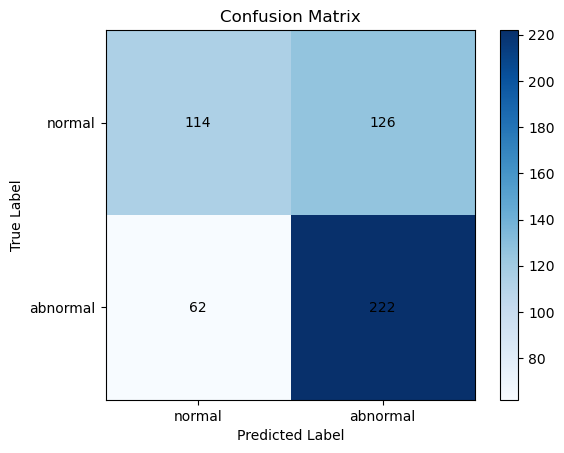

In [27]:
Experiment3 = train(
    model_exp3, 
    X_train, y_train, 
    X_val, y_val,
    X_test, y_test,
    lr=0.010,       
    epochs=30,    
    l2=0.00     
)


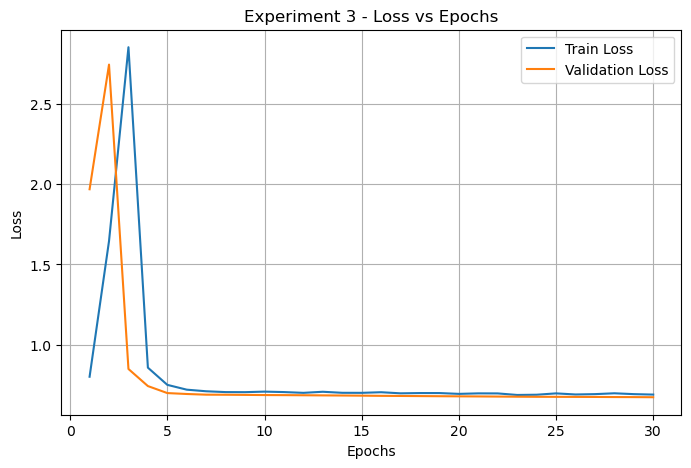

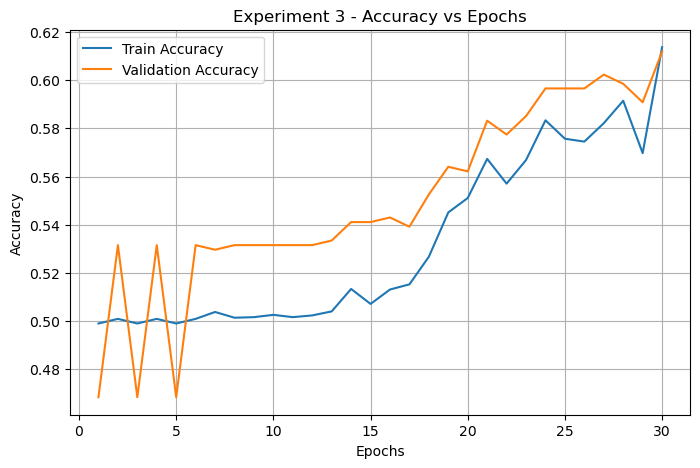

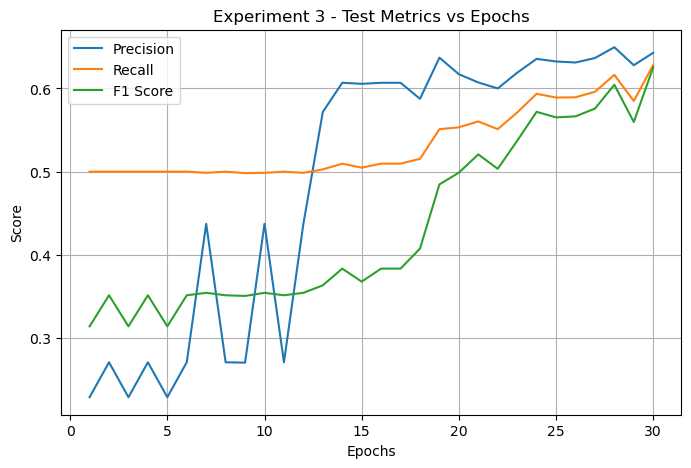

In [28]:
plot_experiment_history(Experiment3, title_prefix="Experiment 3")


Experiment 4 : Since the above experiemnts are stuck at accuracy around 50% hence we might need to experiment 
1. image size
2. batches : Pass the dataset as batches adn not compute gradient descent over the entire dataset 
hence for the next experiment 
image size : 128x128
learning rate : decreasing (0.02)
Architecture: input layer (128x128) -> hidden_layer1 (2048) -> relu()-> drop out 20% -> hidden_layer_2(512) -> reLU() -> drop out 20% -> output layer (2)
3. optimizer : mini batch gradient descent

We will also be computing mini batch gradient descent in order to get optimize results 

In [29]:
def get_batches(X, y, batch_size=64, shuffle=True):
    n = X.shape[0]
    indices = np.arange(n)
    if shuffle:
        np.random.shuffle(indices)
    for start in range(0, n, batch_size):
        end = start + batch_size
        batch_idx = indices[start:end]
        yield X[batch_idx], y[batch_idx]


Loading the dataset, changing the shape to be 128x128,  splitting the dataset into train, test and validation

In [30]:
import numpy as np
from PIL import Image
import glob
import os
def load_image(dataset_dir, size=(128,128)):
    X1=[]   
    y1=[] 
    classes={
        "normal" :0,
        "abnormal": 1
    }
    for class_name, class_label in classes.items():
        folder = os.path.join(dataset_dir,class_name)
        image_paths = glob.glob(folder+"/*.png")
        for path in image_paths:
            img = Image.open(path)
            img = Image.open(path).convert('L')
            img = img.resize(size)
            arr = np.array(img, dtype=np.float32)/255.0
            arr = arr.flatten()
            X1.append(arr)
            y1.append(class_label)
    X = np.array(X1)
    Y = np.array(y1)
    return X,Y

X,Y = load_image("C:/Users/HP/Downloads/dataset-fro-programming&mathsforAI/spectrogramprocessedata/heartbeat-dataset")
import numpy as np

def train_val_test_split(X, y, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=None):
    N = len(X)
    idx = np.arange(N)
    np.random.shuffle(idx)

    train_end = int(N * train_ratio)
    val_end = train_end + int(N * val_ratio)

    train_idx = idx[:train_end]
    val_idx = idx[train_end:val_end]
    test_idx = idx[val_end:]

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, Y, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=42)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (4188, 16384) (4188,)
Validation: (523, 16384) (523,)
Test: (524, 16384) (524,)


In [31]:
def train(model, X_train, y_train, X_val, y_val, X_test, y_test, lr=0.001, epochs=100, l2=0.0, batch_size=64):

    history = {
        "loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "test_acc": [],
        "precision": [],
        "recall": [],
        "f1": []
    }

    for epoch in range(epochs):
        epoch_loss = 0
        n_samples = 0

        for X_batch, y_batch in get_batches(X_train, y_train, batch_size=batch_size):
            logits = model.forward(X_batch, training=True)
            probs = softmax(logits)


            loss = cross_entropy(probs, y_batch)
            loss += (l2 / 2) * sum(np.sum(layer.W**2) for layer in model.layers)


            grad = softmax_backward(probs, y_batch)
            model.backward(grad, l2=l2)

            model.update(lr)

            epoch_loss += loss * X_batch.shape[0]
            n_samples += X_batch.shape[0]

        epoch_loss /= n_samples

        val_logits = model.forward(X_val, training=False)
        val_probs  = softmax(val_logits)
        val_loss   = cross_entropy(val_probs, y_val)
        val_loss  += (l2 / 2) * sum(np.sum(layer.W**2) for layer in model.layers)

        train_preds = model.predict(X_train)
        val_preds   = model.predict(X_val)
        test_preds  = model.predict(X_test)

        train_acc = accuracy(y_train, train_preds)
        val_acc   = accuracy(y_val, val_preds)
        test_acc  = accuracy(y_test, test_preds)

        prec = precision_score(y_test, test_preds, average='macro')
        rec  = recall_score(y_test, test_preds, average='macro')
        f1   = f1_score(y_test, test_preds, average='macro')

        history["loss"].append(epoch_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["test_acc"].append(test_acc)
        history["precision"].append(prec)
        history["recall"].append(rec)
        history["f1"].append(f1)

        print(f"Epoch {epoch+1}/{epochs}  Loss={epoch_loss:.4f}  "
              f"TrainAcc={train_acc:.4f}  ValAcc={val_acc:.4f}  TestAcc={test_acc:.4f}  "
              f"Prec={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")

    final_train_preds = model.predict(X_train)
    final_val_preds   = model.predict(X_val)
    final_test_preds  = model.predict(X_test)

    print("\n=== Final Accuracy ===")
    print(f"Train Accuracy : {accuracy(y_train, final_train_preds):.4f}")
    print(f"Validation Accuracy : {accuracy(y_val, final_val_preds):.4f}")
    print(f"Test Accuracy  : {accuracy(y_test, final_test_preds):.4f}")

    cm = confusion_matrix(y_test, final_test_preds)
    print("\nConfusion Matrix:\n", cm)
    plot_confusion_matrix(cm)

    return history


In [32]:
def model_summary(model):
    print("Layer (type)        Input → Output       # Parameters")
    print("-"*50)
    total_params = 0
    for i, layer in enumerate(model.layers):
        in_dim, out_dim = layer.W.shape
        params = in_dim * out_dim + out_dim
        total_params += params
        layer_type = "Linear"
        print(f"{i+1:2d} ({layer_type:<6})     {in_dim} → {out_dim:<6}     {params}")
    print("-"*50)
    print(f"Total parameters: {total_params}")


In [33]:
model_exp4 = SimpleNN(input_dim=X_train.shape[1], hidden_dims=[2048, 512], output_dim=2, dropout_p=0.2)

In [34]:
model_summary(model_exp4)

Layer (type)        Input → Output       # Parameters
--------------------------------------------------
 1 (Linear)     16384 → 2048       33556480
 2 (Linear)     2048 → 512        1049088
 3 (Linear)     512 → 2          1026
--------------------------------------------------
Total parameters: 34606594


Epoch 1/30  Loss=0.9356  TrainAcc=0.5010  ValAcc=0.5086  TestAcc=0.4714  Prec=0.7337  Recall=0.5071  F1=0.3325


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/30  Loss=0.6981  TrainAcc=0.5045  ValAcc=0.4952  TestAcc=0.5363  Prec=0.2681  Recall=0.5000  F1=0.3491
Epoch 3/30  Loss=0.6898  TrainAcc=0.6507  ValAcc=0.6616  TestAcc=0.6489  Prec=0.7705  Recall=0.6718  F1=0.6219


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/30  Loss=0.6866  TrainAcc=0.5057  ValAcc=0.4990  TestAcc=0.5363  Prec=0.2681  Recall=0.5000  F1=0.3491


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/30  Loss=0.6735  TrainAcc=0.5057  ValAcc=0.4990  TestAcc=0.5363  Prec=0.2681  Recall=0.5000  F1=0.3491
Epoch 6/30  Loss=0.6835  TrainAcc=0.5912  ValAcc=0.5832  TestAcc=0.6431  Prec=0.6521  Recall=0.6297  F1=0.6230
Epoch 7/30  Loss=0.6690  TrainAcc=0.6581  ValAcc=0.6654  TestAcc=0.6622  Prec=0.7762  Recall=0.6842  F1=0.6390


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/30  Loss=0.6656  TrainAcc=0.5057  ValAcc=0.4990  TestAcc=0.5363  Prec=0.2681  Recall=0.5000  F1=0.3491
Epoch 9/30  Loss=0.6650  TrainAcc=0.6165  ValAcc=0.6061  TestAcc=0.6737  Prec=0.6771  Recall=0.6646  F1=0.6635
Epoch 10/30  Loss=0.6531  TrainAcc=0.6851  ValAcc=0.6826  TestAcc=0.7176  Prec=0.7355  Recall=0.7264  F1=0.7162
Epoch 11/30  Loss=0.6574  TrainAcc=0.6621  ValAcc=0.6711  TestAcc=0.6660  Prec=0.7820  Recall=0.6881  F1=0.6430


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12/30  Loss=0.6612  TrainAcc=0.4943  ValAcc=0.5010  TestAcc=0.4637  Prec=0.2319  Recall=0.5000  F1=0.3168
Epoch 13/30  Loss=0.6634  TrainAcc=0.5344  ValAcc=0.5277  TestAcc=0.5840  Prec=0.6228  Recall=0.5578  F1=0.5044
Epoch 14/30  Loss=0.6439  TrainAcc=0.6550  ValAcc=0.6597  TestAcc=0.6584  Prec=0.7833  Recall=0.6812  F1=0.6325
Epoch 15/30  Loss=0.6610  TrainAcc=0.6889  ValAcc=0.6922  TestAcc=0.6927  Prec=0.7459  Recall=0.7082  F1=0.6844
Epoch 16/30  Loss=0.6405  TrainAcc=0.6681  ValAcc=0.6769  TestAcc=0.6756  Prec=0.7859  Recall=0.6970  F1=0.6550
Epoch 17/30  Loss=0.6539  TrainAcc=0.5246  ValAcc=0.5335  TestAcc=0.4866  Prec=0.7373  Recall=0.5214  F1=0.3628
Epoch 18/30  Loss=0.6586  TrainAcc=0.5571  ValAcc=0.5602  TestAcc=0.5382  Prec=0.7505  Recall=0.5694  F1=0.4557
Epoch 19/30  Loss=0.6374  TrainAcc=0.5831  ValAcc=0.5870  TestAcc=0.5763  Prec=0.7613  Recall=0.6050  F1=0.5167


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/30  Loss=0.6279  TrainAcc=0.5076  ValAcc=0.4952  TestAcc=0.5363  Prec=0.2681  Recall=0.5000  F1=0.3491
Epoch 21/30  Loss=0.6324  TrainAcc=0.6956  ValAcc=0.7094  TestAcc=0.7233  Prec=0.7432  Recall=0.7325  F1=0.7217
Epoch 22/30  Loss=0.6334  TrainAcc=0.6320  ValAcc=0.6367  TestAcc=0.6374  Prec=0.7806  Recall=0.6619  F1=0.6041
Epoch 23/30  Loss=0.6454  TrainAcc=0.5308  ValAcc=0.5430  TestAcc=0.4981  Prec=0.7401  Recall=0.5320  F1=0.3846
Epoch 24/30  Loss=0.6422  TrainAcc=0.6187  ValAcc=0.6252  TestAcc=0.6202  Prec=0.7749  Recall=0.6459  F1=0.5806
Epoch 25/30  Loss=0.6108  TrainAcc=0.6292  ValAcc=0.6138  TestAcc=0.6870  Prec=0.6877  Recall=0.6804  F1=0.6807


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 26/30  Loss=0.6463  TrainAcc=0.5074  ValAcc=0.4971  TestAcc=0.5363  Prec=0.2681  Recall=0.5000  F1=0.3491
Epoch 27/30  Loss=0.6399  TrainAcc=0.6511  ValAcc=0.6558  TestAcc=0.6565  Prec=0.7872  Recall=0.6797  F1=0.6293
Epoch 28/30  Loss=0.6120  TrainAcc=0.7056  ValAcc=0.7228  TestAcc=0.7099  Prec=0.7495  Recall=0.7231  F1=0.7050
Epoch 29/30  Loss=0.6030  TrainAcc=0.6767  ValAcc=0.6769  TestAcc=0.6794  Prec=0.7875  Recall=0.7005  F1=0.6597
Epoch 30/30  Loss=0.6094  TrainAcc=0.7137  ValAcc=0.7266  TestAcc=0.7271  Prec=0.7536  Recall=0.7378  F1=0.7247

=== Final Accuracy ===
Train Accuracy : 0.7137
Validation Accuracy : 0.7266
Test Accuracy  : 0.7271

Confusion Matrix:
 [[215  28]
 [115 166]]


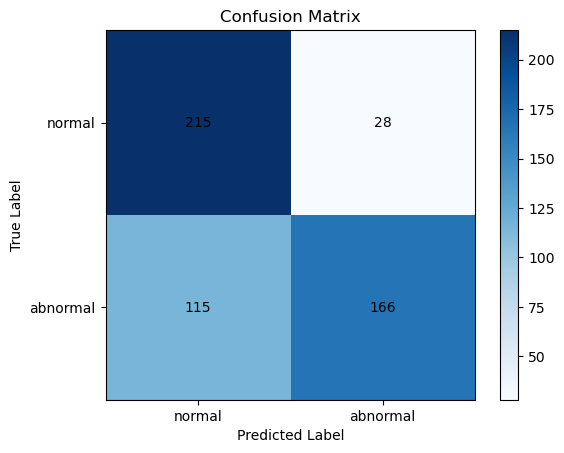

In [35]:
Experiment4 = train(
    model_exp4, 
    X_train, y_train, 
    X_val, y_val,
    X_test, y_test,
    lr=0.02,       
    epochs=30,    
    l2=0.00     
)


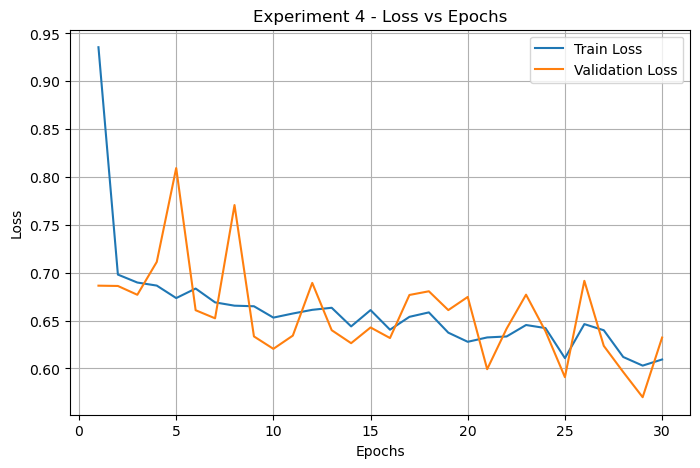

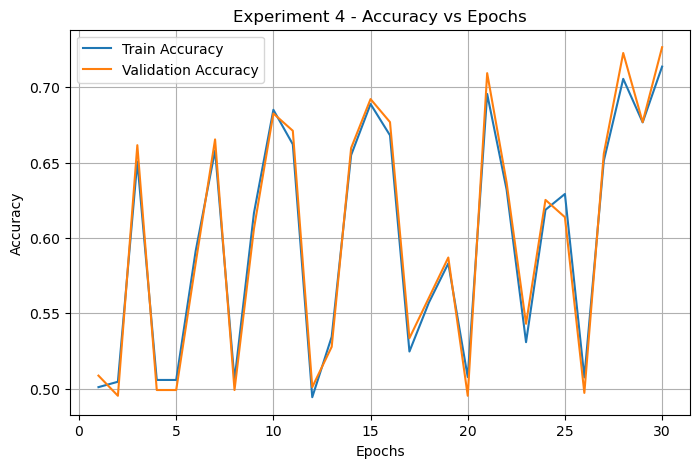

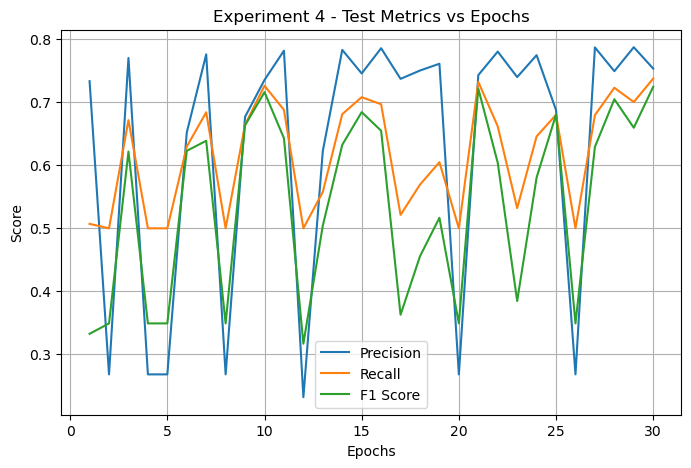

In [36]:
plot_experiment_history(Experiment4, title_prefix="Experiment 4")


Experiment 5: Since the above experiemnts are stuck at accuracy around 50% hence we might need to experiment 
1. image size
2. batches : Pass the dataset as batches adn not compute gradient descent over the entire dataset 
hence for the next experiment 
image size : 128x128
learning rate : decreased from (0.02) to (0.001)
Architecture: input layer (128x128) -> hidden_layer1 (2048) -> relu()-> drop out 20% -> hidden_layer_2(512) -> reLU() -> drop out 20% -> output layer (2)
3. optimizer : mini batch gradient descent
4. Number of epochs : 70

Epoch 1/70  Loss=0.5999  TrainAcc=0.7051  ValAcc=0.7170  TestAcc=0.7137  Prec=0.7574  Recall=0.7275  F1=0.7082
Epoch 2/70  Loss=0.5651  TrainAcc=0.7011  ValAcc=0.7017  TestAcc=0.7023  Prec=0.7481  Recall=0.7166  F1=0.6959
Epoch 3/70  Loss=0.5553  TrainAcc=0.7003  ValAcc=0.7017  TestAcc=0.7023  Prec=0.7500  Recall=0.7169  F1=0.6955
Epoch 4/70  Loss=0.5553  TrainAcc=0.7011  ValAcc=0.7036  TestAcc=0.7099  Prec=0.7512  Recall=0.7234  F1=0.7047
Epoch 5/70  Loss=0.5526  TrainAcc=0.7001  ValAcc=0.7036  TestAcc=0.7023  Prec=0.7540  Recall=0.7174  F1=0.6948
Epoch 6/70  Loss=0.5523  TrainAcc=0.6960  ValAcc=0.6960  TestAcc=0.6947  Prec=0.7584  Recall=0.7114  F1=0.6845
Epoch 7/70  Loss=0.5517  TrainAcc=0.6958  ValAcc=0.7017  TestAcc=0.6985  Prec=0.7538  Recall=0.7141  F1=0.6901
Epoch 8/70  Loss=0.5499  TrainAcc=0.7011  ValAcc=0.7036  TestAcc=0.7042  Prec=0.7474  Recall=0.7181  F1=0.6983
Epoch 9/70  Loss=0.5507  TrainAcc=0.6956  ValAcc=0.7036  TestAcc=0.6985  Prec=0.7583  Recall=0.7147  F1=0.6893
E

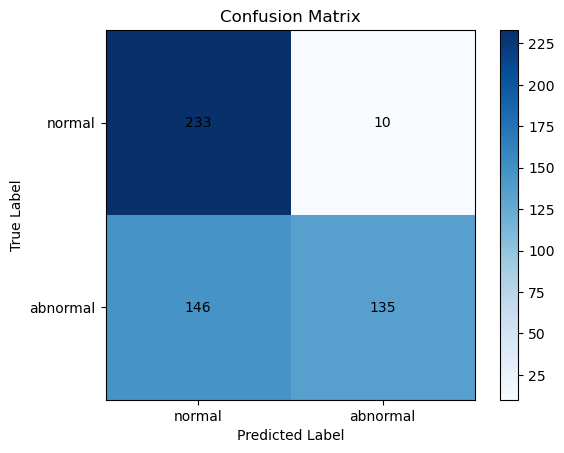

In [37]:
Experiment5 = train(
    model_exp4, 
    X_train, y_train, 
    X_val, y_val,
    X_test, y_test,
    lr=0.001,       
    epochs=70,    
    l2=0.00     
)


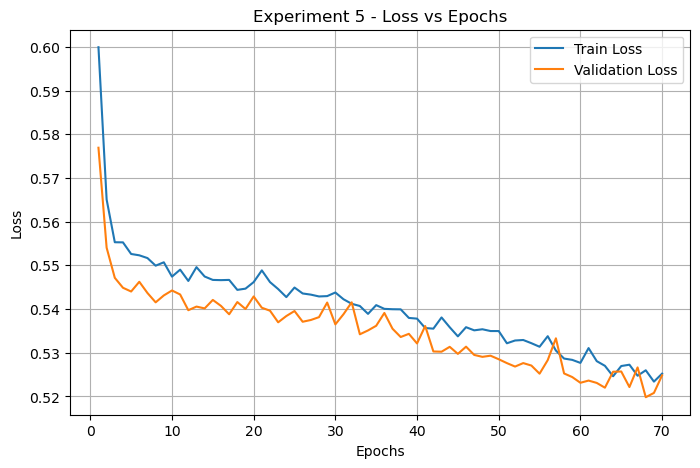

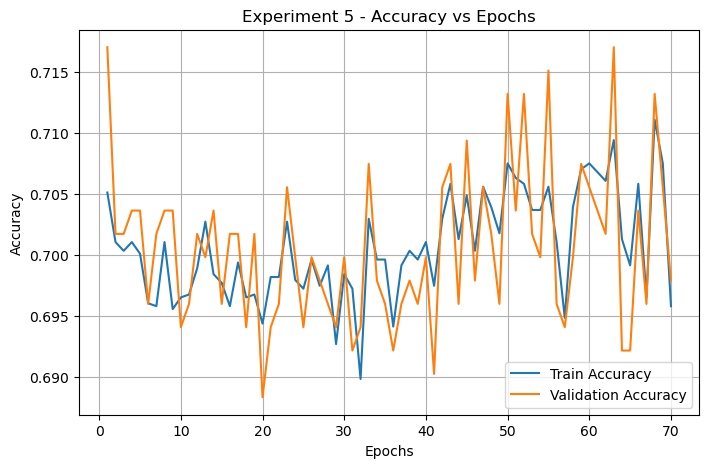

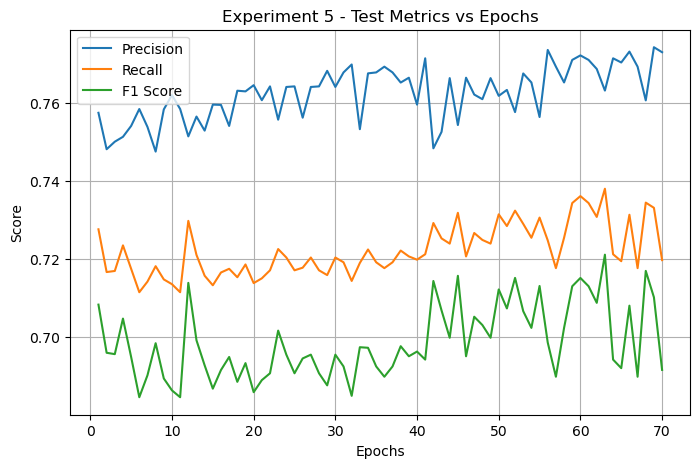

In [40]:
plot_experiment_history(Experiment5, title_prefix="Experiment 5")


Experiment 6: Since the above experiemnts are stuck at accuracy around 50% hence we might need to experiment 
Keeping all parameters same as experiment number 5 only changing the learning rate to 0.01 from 0.02 (decreasing in order to reduce the sharp curves during the learning)

In [41]:
model_exp5 = SimpleNN(input_dim=X_train.shape[1], hidden_dims=[2048, 512], output_dim=2, dropout_p=0.2)

Epoch 1/100  Loss=0.7434  TrainAcc=0.4943  ValAcc=0.5010  TestAcc=0.4656  Prec=0.7323  Recall=0.5018  F1=0.3208


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/100  Loss=0.6954  TrainAcc=0.5048  ValAcc=0.4933  TestAcc=0.5363  Prec=0.2681  Recall=0.5000  F1=0.3491
Epoch 3/100  Loss=0.6864  TrainAcc=0.5425  ValAcc=0.5488  TestAcc=0.5172  Prec=0.7450  Recall=0.5498  F1=0.4194
Epoch 4/100  Loss=0.6721  TrainAcc=0.6882  ValAcc=0.6902  TestAcc=0.7099  Prec=0.7461  Recall=0.7226  F1=0.7055
Epoch 5/100  Loss=0.6685  TrainAcc=0.6488  ValAcc=0.6405  TestAcc=0.6927  Prec=0.6914  Recall=0.6918  F1=0.6915
Epoch 6/100  Loss=0.6583  TrainAcc=0.6877  ValAcc=0.6922  TestAcc=0.7023  Prec=0.7481  Recall=0.7166  F1=0.6959
Epoch 7/100  Loss=0.6504  TrainAcc=0.6796  ValAcc=0.6883  TestAcc=0.6737  Prec=0.7635  Recall=0.6935  F1=0.6565
Epoch 8/100  Loss=0.6416  TrainAcc=0.5263  ValAcc=0.5010  TestAcc=0.5515  Prec=0.5763  Recall=0.5206  F1=0.4287
Epoch 9/100  Loss=0.6379  TrainAcc=0.6743  ValAcc=0.6730  TestAcc=0.7061  Prec=0.7055  Recall=0.7065  F1=0.7055
Epoch 10/100  Loss=0.6345  TrainAcc=0.6380  ValAcc=0.6463  TestAcc=0.6374  Prec=0.7806  Recall=0.6619  F

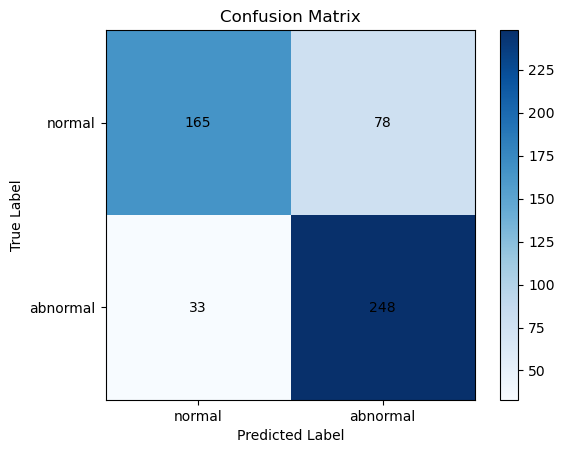

In [42]:
Experiment6 = train(
    model_exp5, 
    X_train, y_train, 
    X_val, y_val,
    X_test, y_test,
    lr=0.001,       
    epochs=100,    
    l2=0.00     
)


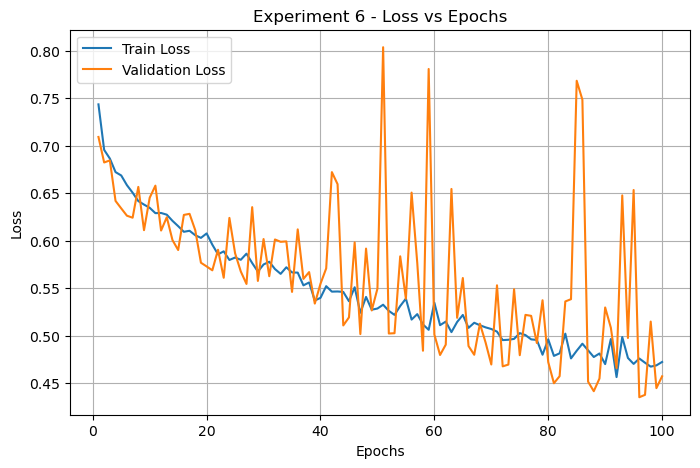

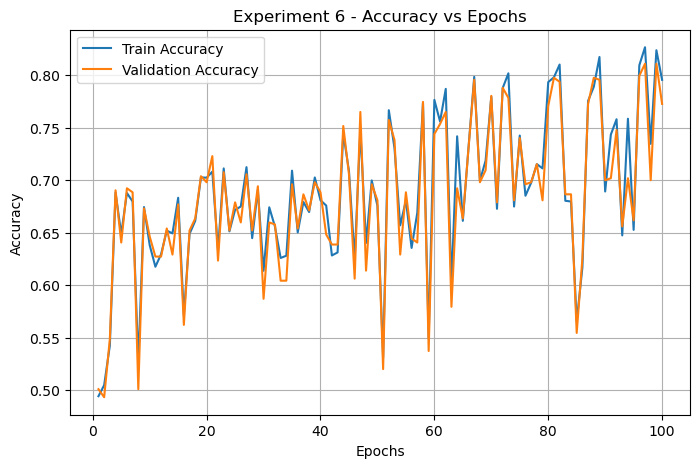

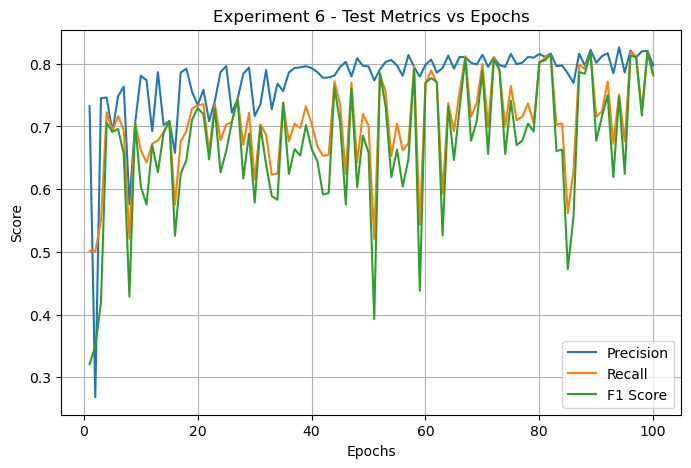

In [43]:
plot_experiment_history(Experiment6, title_prefix="Experiment 6")


Priting the final metrics for the above architecture (training, testign and valdiation)

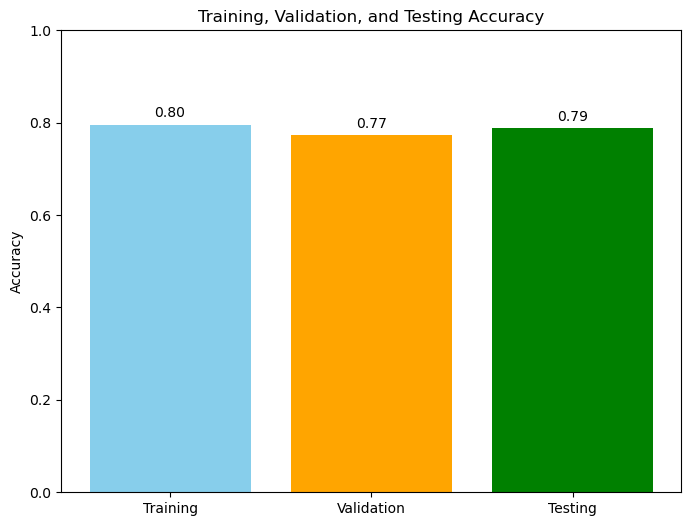

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Extract final training and validation accuracies
train_acc = Experiment6['train_acc'][-1]
val_acc = Experiment6['val_acc'][-1]

# Compute test accuracy
y_pred = model_exp5.predict(X_test)
test_acc = np.mean(y_pred == y_test)

# Prepare data
accuracies = [train_acc, val_acc, test_acc]
labels = ['Training', 'Validation', 'Testing']

# Plot
plt.figure(figsize=(8,6))
bars = plt.bar(labels, accuracies, color=['skyblue', 'orange', 'green'])
plt.ylim(0, 1)  # accuracy between 0 and 1
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Testing Accuracy')

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.show()


Implementing the experiment 6 architecture on the raw audio data in order to understand how it performs on raw audio data 